# TP Clasificador Bayesiano LDA

- José Ivan Hertter
- Ezequiel Diaz Guzman

In [578]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [579]:
N = -1
data = pd.read_csv('data/alturas-pesos-mils-train.csv')[:N]
validation = pd.read_csv('data/alturas-pesos-mils-test.csv')[:N]

In [580]:
data_hombres = data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres = data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values

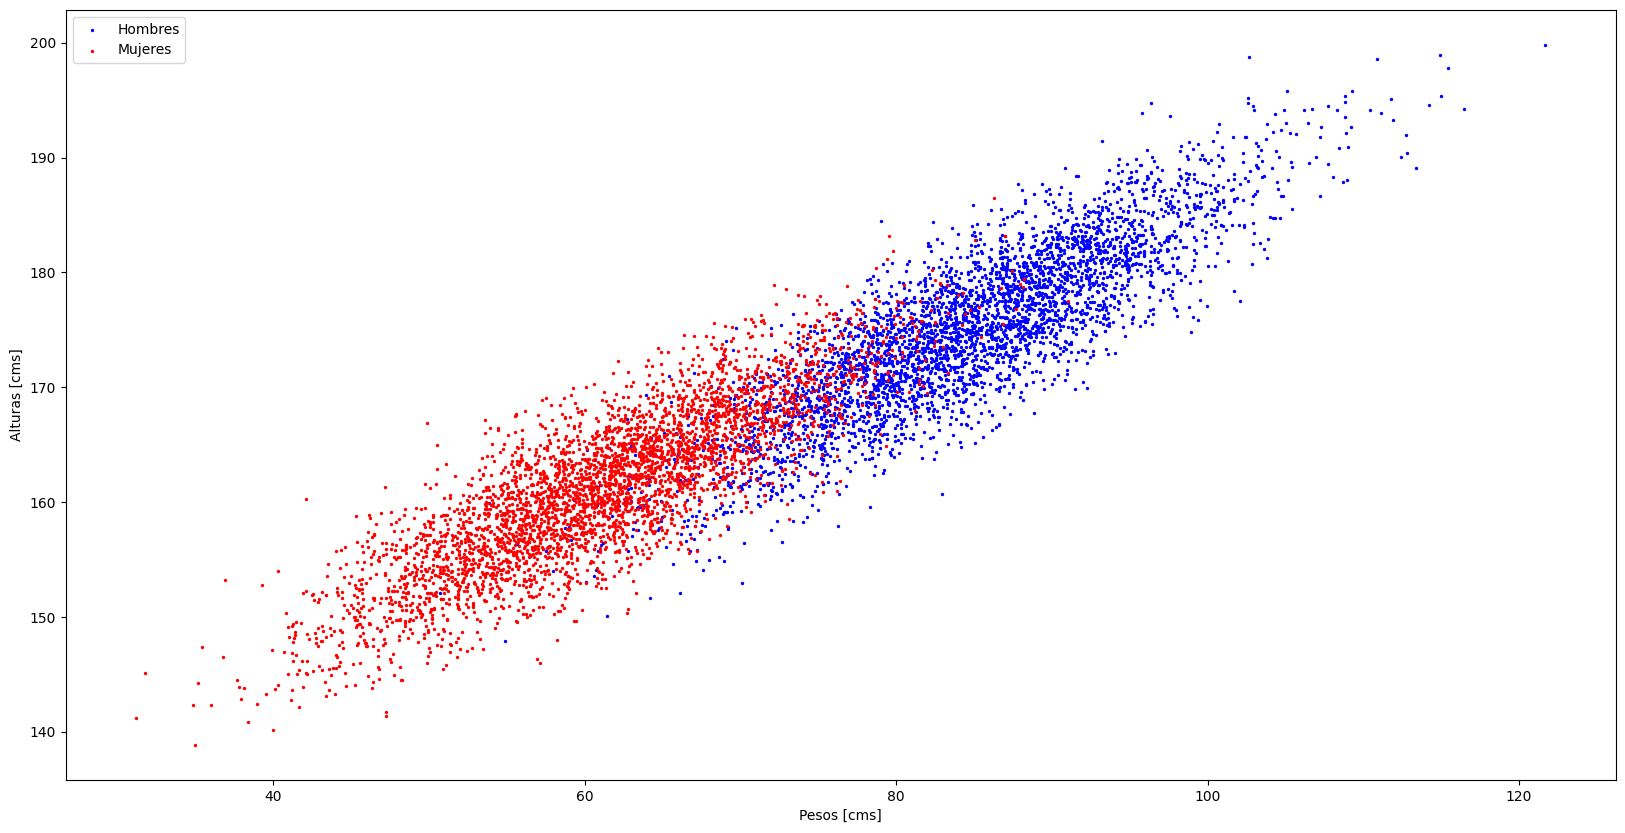

In [581]:
# Grafico de los datos
# %matplotlib qt
f = plt.figure(figsize=(20,10))
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, label='Hombres')
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, label='Mujeres')
plt.xlabel('Pesos [cms]')
plt.ylabel('Alturas [cms]')
plt.legend()
plt.show()

In [582]:
from scipy.stats import multivariate_normal

In [583]:
def get_gauss_prob(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres)
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres)
    N_class_1 = len(data_hombres)
    N_class_2 = len(data_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    
    return p_class_1, p_class_2

In [584]:
def get_acc_gauss(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    p_class_1, p_class_2 = get_gauss_prob(data[['Peso', 'Altura']].values, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
    return ((p_class_1>p_class_2)==(data['Genero']=='Hombre')).sum()/len(p_class_1)

Cálculo de la covarianza:
Recordamos que para dos variables aleatorias X, Y: $$Cov(X,Y) = \frac{\Sigma_{i=1}^n(x_i-x_{med})(y_i-y_{med})}{n}$$

In [585]:
mean_hombres = data_hombres.mean(axis=0)
mean_mujeres = data_mujeres.mean(axis=0)
cov_LDA = np.cov(np.vstack([data_hombres - mean_hombres, data_mujeres - mean_mujeres]).T)

## Accuracy de Train:

In [586]:
acc_train_LDA = get_acc_gauss(data, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)
print('Accuracy LDA:', acc_train_LDA)

Accuracy LDA: 0.9167395924490561


## Accuracy de Validación:

In [587]:
acc_val_LDA = get_acc_gauss(validation, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)
print(acc_val_LDA)

0.9224612306153076


In [588]:
N = 300
X = np.linspace(data['Peso'].min(), data['Peso'].max(), N)
Y = np.linspace(data['Altura'].min(), data['Altura'].max(), N)
X, Y = np.meshgrid(X, Y)
# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
# The distribution on the variables X, Y packed into pos.
Z_H_LDA = multivariate_normal.pdf(pos, mean_hombres, cov_LDA)
Z_M_LDA = multivariate_normal.pdf(pos, mean_mujeres, cov_LDA)
Z_LDA, _ = get_gauss_prob(pos, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)

Ploteo del umbral de decisión junto a los datos

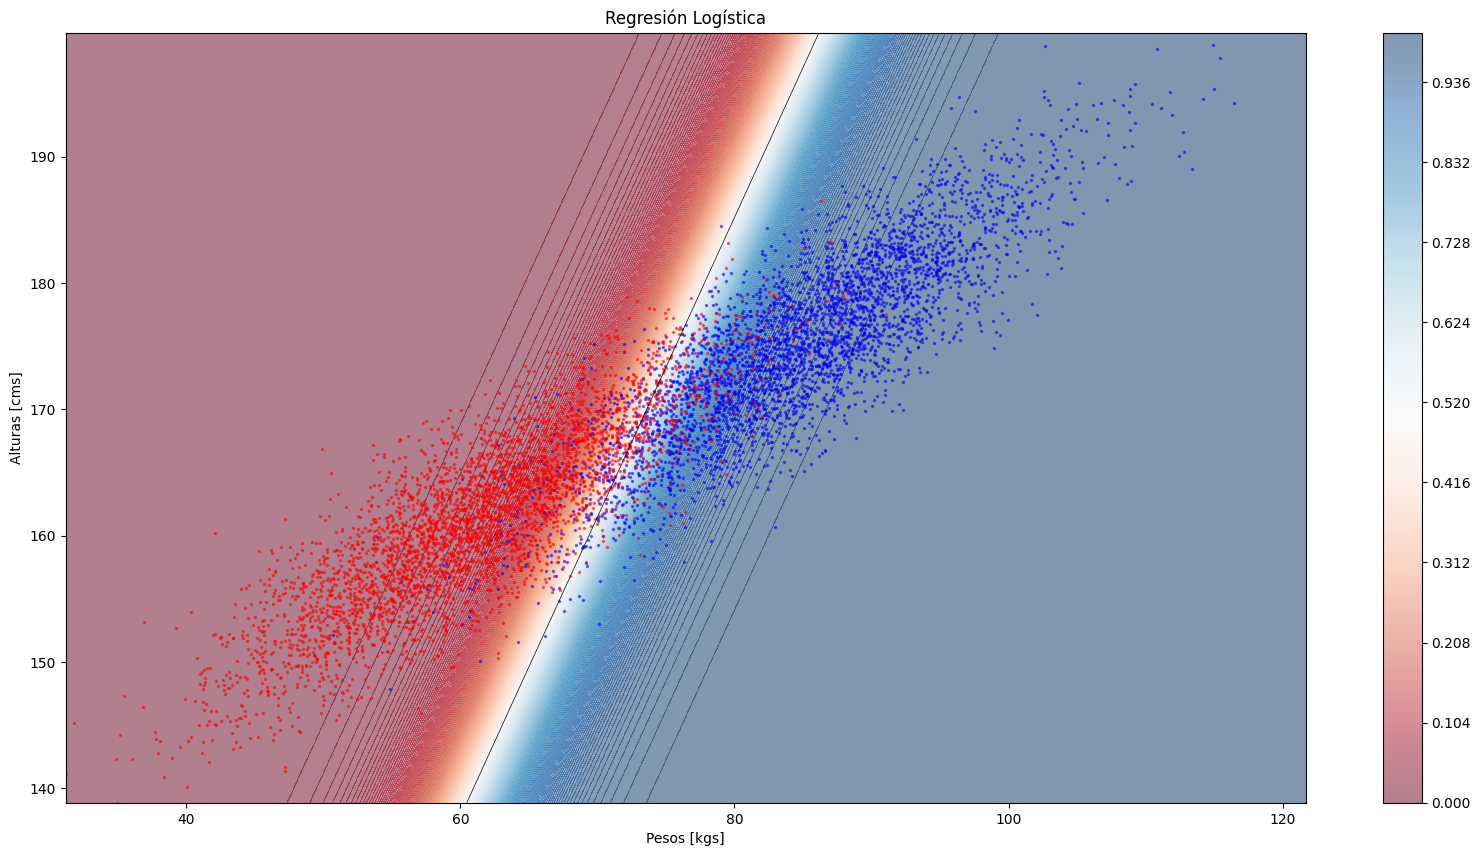

In [589]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_LDA, 256, alpha=.5, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
ax.contour(X, Y, Z_LDA, (0.5,), colors='k', linewidths=0.5)
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.title('Regresión Logística')
plt.show()

Cálculo de W y c

In [590]:
W = np.linalg.inv(cov_LDA).dot(mean_hombres - mean_mujeres)
C = np.log(data_hombres.shape[0]/data_mujeres.shape[0]) - 0.5*(mean_hombres + mean_mujeres).T.dot(W)
print("W:", W)
print("C:", C) 

W: [ 0.42107303 -0.17751662]
C: -0.8097757716403916


In [591]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [592]:
model = LinearDiscriminantAnalysis()
model.fit(data[['Peso', 'Altura']], data['Genero'])
print(model.get_params())

{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}


In [593]:
skl_acc_train = model.score(data[['Peso', 'Altura']], data['Genero'])
skl_acc_validation = model.score(validation[['Peso', 'Altura']], validation['Genero'])
print(f'SKL Accuracy Train: {skl_acc_train}')
print(f'SKL Accuracy Validation: {skl_acc_validation}')
print(f'Accuracy Train: {acc_train_LDA}')
print(f'Accuracy Validation: {acc_val_LDA}')

SKL Accuracy Train: 0.9167395924490561
SKL Accuracy Validation: 0.9224612306153076
Accuracy Train: 0.9167395924490561
Accuracy Validation: 0.9224612306153076


Accuracy de validación "a mano"

In [594]:
print("Accuracy Validation: ", (model.predict(validation[['Peso','Altura']])==(validation['Genero'])).sum()/len(validation))

Accuracy Validation:  0.9224612306153076


In [595]:
# parámetros C y W del modelo de sklearn
print("C:", model.intercept_[0])
print("W:", model.coef_[0])

C: 0.8096744305744656
W: [-0.42102039  0.17749442]


### Observaciones:
Tanto el vector de pesos W como el término constante C son inversos comparados al cálculo manual anteriormente hecho.
Se intuye que tiene que ver con el espacio interno utilizado para la representación de los datos. Ya que esto significaría que tanto el sesgo como la inclinación de la frontera de decisión "apuntan hacia el lado contrario" y, por lo tanto, que los datos de mujeres están "a la derecha" de la misma, y los de los hombres, "a la izquierda"

# Reentrenamiento con extensión cuadrática

In [596]:
# Genero arreglos con los datos "nuevos"

data['p_squared'] = data['Peso'] ** 2
data['a_squared'] = data['Altura'] ** 2
data['p_a'] = data['Peso'] * data['Altura']

validation['p_squared'] = validation['Peso'] ** 2
validation['a_squared'] = validation['Altura'] ** 2
validation['p_a'] = validation['Peso'] * validation['Altura']

# Crear el conjunto de características extendido
data_extended = data[['Peso', 'p_squared', 'Altura', 'a_squared', 'p_a']].values
validation_extended = validation[['Peso', 'p_squared', 'Altura', 'a_squared', 'p_a']].values

# Reentrenar el modelo
model_ce = LinearDiscriminantAnalysis()
model_ce.fit(data_extended, data['Genero'])

# Imprimir los coeficientes y el sesgo
print("W:", model_ce.coef_[0])
print("C:", model_ce.intercept_[0])

W: [-1.15015182 -0.00135326  1.2966605  -0.00452444  0.00550952]
C: -66.64880846634267


In [597]:
acc_train_ce = model_ce.score(data_extended, data['Genero'])
acc_val_ce = model_ce.score(validation_extended, validation['Genero'])
print(f'Accuracy Train: {acc_train_ce}')
print(f'Accuracy Validation: {acc_val_ce}')

Accuracy Train: 0.9157394674334292
Accuracy Validation: 0.919959979989995


#### Observaciones #2
- El umbral de decisión ahora tiene 5 dimensiones, por lo que no lo consideramos lineal
- El modelo tiene 5 parámetros (componentes de W), y un "término constante" (C)
- Antes, el modelo tenía 2 parámetros (componentes de W) y un término constante.
- Las métricas de train y validación para SKLEARN:
    - Accuracy Train: 0.9157394674334292
    - Accuracy Validation: 0.919959979989995

# Logistic Regression

In [598]:
from sklearn.linear_model import LogisticRegression

In [599]:
model_LR = LogisticRegression()
model_LR.set_params(C=1e12)
model_LR.fit(data[['Peso', 'Altura']], data['Genero'], 1e12)

LogisticRegression(C=1000000000000.0)

In [600]:
print("Model Params: ", model_LR.get_params())

Model Params:  {'C': 1000000000000.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [601]:
print("Accuracy Train: ", model_LR.score(data[['Peso', 'Altura']], data['Genero']))
print("Accuracy Validation: ", model_LR.score(validation[['Peso', 'Altura']], validation['Genero']))

Accuracy Train:  0.9166145768221028
Accuracy Validation:  0.9219609804902451


In [602]:
print("W:", model_LR.coef_[0])
print("C:", model_LR.intercept_[0])

W: [-0.42864249  0.18550112]
C: 0.0034746195112742052


In [603]:
Z_lr = model_LR.predict_proba(pos.reshape(-1, 2))[:, 1].reshape(pos.shape[:2])

c:\Users\hertt\ITBA\TP-ClasificadorBayesiano\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


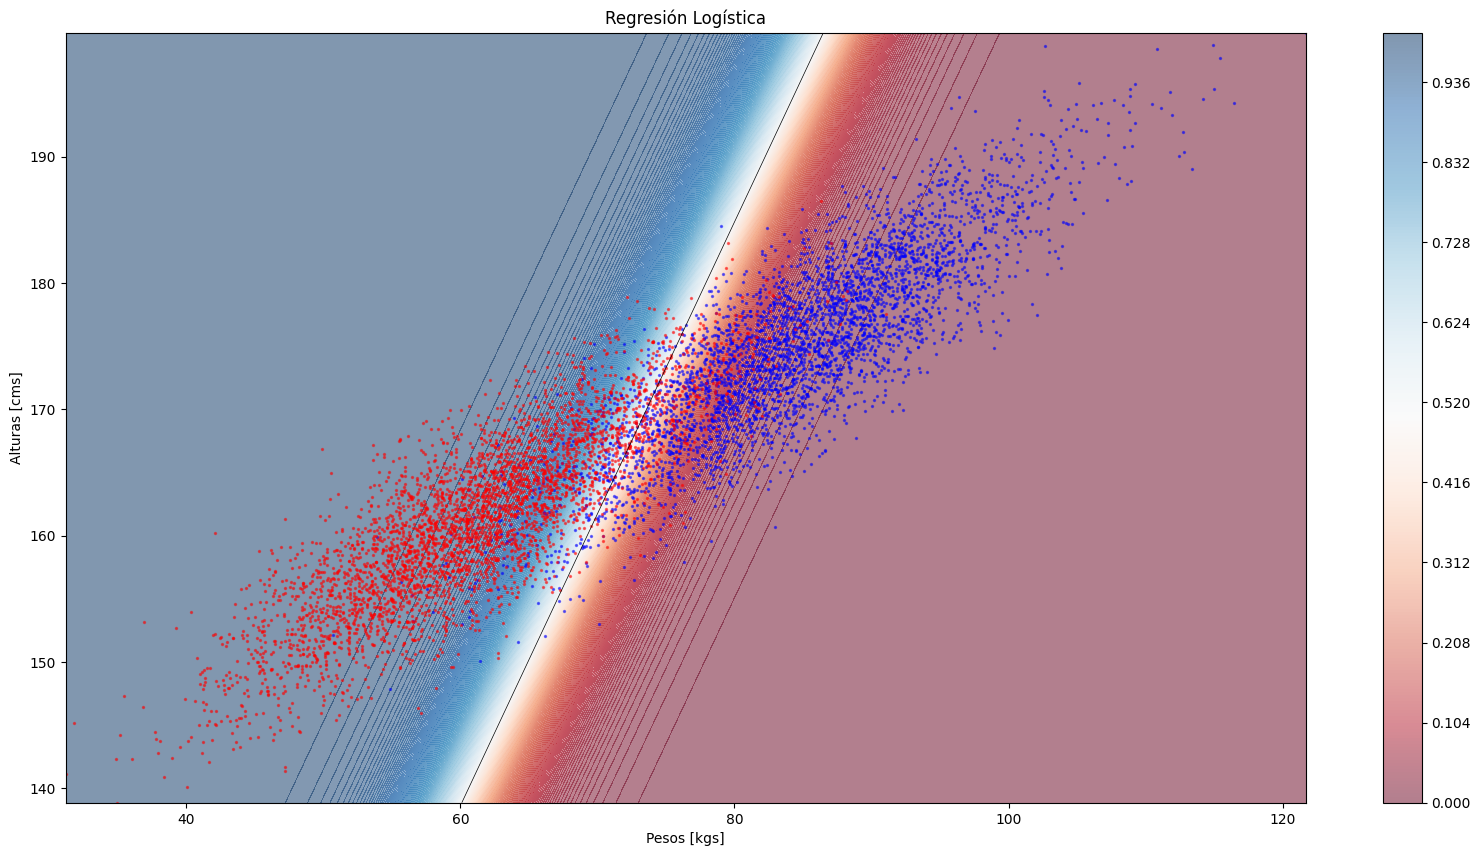

In [604]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_lr, 256, alpha=.5, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
ax.contour(X, Y, Z_lr, (0.5,), colors='k', linewidths=0.5)
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.title('Regresión Logística')
plt.show()

#### Observaciones #3
Que estén "invertidos" los colores azul y rojo, indica por qué los valores de W y C están invertidos respecto del cálculo manual.